# Multi-Agent Researcher with MCP Support

This notebook demonstrates how to use the multi-agent research system with Model Context Protocol (MCP) support. It follows the same patterns as the original multi_agent.ipynb but adds MCP integration.

In [34]:
%cd ..
%load_ext autoreload
%autoreload 2

/Users/bartolli/Projects/playgound/open_deep_research_05/open_deep_research
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import uuid 
import os
import open_deep_research   
print(open_deep_research.__version__) 
from IPython.display import Image, display, Markdown
from langgraph.checkpoint.memory import MemorySaver
import logging

# Set up logging for better visibility
logging.basicConfig(level=logging.INFO)

0.0.15


## Configure MCP Server

We'll use the example MCP server that provides patient data.

In [36]:
# Get the path to the example_mcp_server.py 
import pathlib
repo_root = pathlib.Path(".").resolve()
example_server_path = str(repo_root / "src" / "open_deep_research" / "example_mcp_server.py")

# Check if file exists
print(f"Example MCP server path: {example_server_path}")
print(f"File exists: {pathlib.Path(example_server_path).exists()}")

# Try alternate locations if not found
if not pathlib.Path(example_server_path).exists():
    alternate_path = str(repo_root / "open_deep_research" / "example_mcp_server.py")
    print(f"Trying alternate path: {alternate_path}")
    print(f"Alternate path exists: {pathlib.Path(alternate_path).exists()}")
    if pathlib.Path(alternate_path).exists():
        example_server_path = alternate_path

# Define MCP server configuration
mcp_servers_config = {
    "patient_data": {
        "transport": "stdio",
        "command": "python",
        "args": [example_server_path],
    }
}

Example MCP server path: /Users/bartolli/Projects/playgound/open_deep_research_05/open_deep_research/src/open_deep_research/example_mcp_server.py
File exists: True


## Build the Graph with MCP Support

Instead of directly using supervisor_g.compile(), we'll use the build_graph_with_mcp function.

In [37]:
# Import the build_graph_with_mcp function
from open_deep_research.multi_agent_new import build_graph_with_mcp, supervisor_g

# Create a MemorySaver for checkpointing
checkpointer = MemorySaver()

# Create base configuration with proper model specifications
base_config = {
    "thread_id": str(uuid.uuid4()),
    "search_api": "tavily",
    "supervisor_model": "anthropic:claude-3-5-sonnet-latest",  # Use appropriate model
    "researcher_model": "anthropic:claude-3-5-sonnet-latest",  # Use appropriate model
    "mcp_servers": mcp_servers_config,
    "_mcp_servers_config": mcp_servers_config,
}

# This is a notebook-specific adaptation that combines build_graph_with_mcp with checkpointer
async def build_graph_with_checkpointer(cfg):
    # First get the MCP configuration but don't create the manager yet (like in build_graph_with_mcp)
    from open_deep_research.configuration import Configuration
    
    cfg = cfg or {}
    configurable = Configuration.from_runnable_config(cfg)
    mcp_servers = configurable.mcp_servers
    
    # Store MCP servers config in a special key (same as build_graph_with_mcp)
    if mcp_servers:
        print(f"MCP servers configured: {list(mcp_servers.keys())}")
        if "configurable" not in cfg:
            cfg["configurable"] = {}
        cfg["configurable"]["_mcp_servers_config"] = mcp_servers
    
    # Now compile with checkpointer (different from build_graph_with_mcp)
    g = supervisor_g.compile(name="research_team", checkpointer=checkpointer)
    
    # Apply config after compilation
    g = g.with_config(cfg)
    
    # Return in the same format as build_graph_with_mcp
    return g, None, cfg

# Build the graph using our adapted function
agent, _, thread_config = await build_graph_with_checkpointer(base_config)

MCP servers configured: ['patient_data']


## Visualize the Graph Structure

This shows how supervisor and research agents are connected in the workflow.

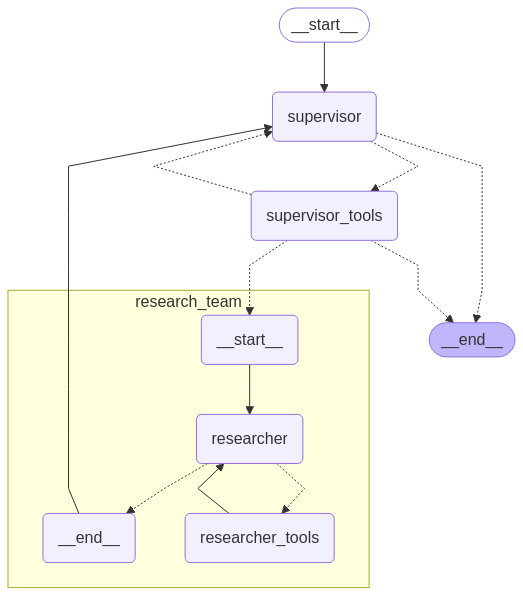

In [38]:
display(Image(agent.get_graph(xray=1).draw_mermaid_png(max_retries=5)))

## Run the Multi-Agent System

We'll use a focused query that leverages the patient data from the MCP server.

In [39]:
# Define the research topic as a user message
msg = [{"role": "user", "content": "Check what we know about patient with id P001 and conduct  research on the latest treatment approaches and management strategies for these conditions."}]

# Create a properly structured config dictionary for invoking the agent
access_config = {
    "configurable": {
        "thread_id": base_config["thread_id"],
        "mcp_servers": base_config["mcp_servers"],
        "_mcp_servers_config": base_config["_mcp_servers_config"],
    }
}

# Run the multi-agent workflow with the properly structured configuration
response = await agent.ainvoke({"messages": msg}, config=access_config)

2025-05-05 15:58:09,167 - open_deep_research.multi_agent_new - WARNING - No MCP tools found in configuration
2025-05-05 15:58:09,168 - open_deep_research.multi_agent_new - INFO - Supervisor tools available: ['tavily_search', 'Sections', 'Introduction', 'Conclusion']
2025-05-05 15:58:10,543 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-05 15:58:10,545 - open_deep_research.mcp_integration - INFO - Creating MCP manager with servers: ['patient_data']
2025-05-05 15:58:10,546 - open_deep_research.mcp_integration - INFO - Initializing MCP client with servers: ['patient_data']
2025-05-05 15:58:10,546 - open_deep_research.mcp_integration - INFO - Server patient_data config: transport=stdio
2025-05-05 15:58:10,546 - open_deep_research.mcp_integration - INFO -   Command: python /Users/bartolli/Projects/playgound/open_deep_research_05/open_deep_research/src/open_deep_research/example_mcp_server.py
2025-05-05 15:58:10,706 - open_deep_resear

## View the Supervisor's Response

In [40]:
# Create a properly structured config dictionary for state access
access_config = {
    "configurable": {
        "thread_id": base_config["thread_id"],
        "mcp_servers": base_config["mcp_servers"],
        "_mcp_servers_config": base_config["_mcp_servers_config"],
    }
}

# Then use this properly structured config to access the state
messages = agent.get_state(access_config).values['messages']
messages[-1].pretty_print()

================================== Ai Message ==================================

Here’s what we currently know about patient P001:

Clinical Data:
- Vitals: All within normal limits (heart rate 72, blood pressure 120/80, temperature 36.8°C, respiratory rate 16, oxygen saturation 98% as of 2025-05-03).
- Current Conditions:
  1. Type 2 Diabetes Mellitus (ICD E11.9) – Diagnosed July 2023, moderate severity, managed.
  2. Essential Hypertension (ICD I10) – Diagnosed March 2022, mild severity, active.
- Scheduled Check: HbA1c test on 2025-05-10 (routine, fasting required).

Requested Action:
You’ve asked for research on the latest treatment and management strategies for these conditions (Type 2 Diabetes Mellitus and Essential Hypertension).

Before proceeding:
1. Is the focus solely on general adult management, or are there any specific patient-related factors (age, comorbidities, medication intolerances, preferences) that should be considered?
2. Are you interested in pharmacological tre

## Add Clarification if Needed

If the supervisor asks for clarification, we can add more details.

In [41]:
# Create a follow-up message with your clarification
follow_up_msg = [
    {"role": "user", "content": "Focus on the latest integrated management approaches for these comorbid conditions from recent medical literature in 2024-2025. Include both pharmacological and lifestyle interventions. Give special attention to treatments suitable for a patient with moderate Type 2 Diabetes and mild Hypertension like P001."}
]

# Create a properly structured config dictionary for state access
access_config = {
    "configurable": {
        "thread_id": base_config["thread_id"],
        "mcp_servers": base_config["mcp_servers"],
        "_mcp_servers_config": base_config["_mcp_servers_config"],
    }
}

# Run the multi-agent workflow again with your clarification
response = await agent.ainvoke({"messages": follow_up_msg}, config=access_config)

# Check the response
messages = agent.get_state(access_config).values['messages']
messages[-1].pretty_print()

2025-05-05 15:58:54,096 - open_deep_research.multi_agent_new - WARNING - No MCP tools found in configuration
2025-05-05 15:58:54,096 - open_deep_research.multi_agent_new - INFO - Supervisor tools available: ['tavily_search', 'Sections', 'Introduction', 'Conclusion']
2025-05-05 15:58:55,340 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-05 15:58:55,343 - open_deep_research.mcp_integration - INFO - Creating MCP manager with servers: ['patient_data']
2025-05-05 15:58:55,343 - open_deep_research.mcp_integration - INFO - Initializing MCP client with servers: ['patient_data']
2025-05-05 15:58:55,343 - open_deep_research.mcp_integration - INFO - Server patient_data config: transport=stdio
2025-05-05 15:58:55,344 - open_deep_research.mcp_integration - INFO -   Command: python /Users/bartolli/Projects/playgound/open_deep_research_05/open_deep_research/src/open_deep_research/example_mcp_server.py
2025-05-05 15:58:55,500 - open_deep_resear

================================== Ai Message ==================================

Summary of What We Know:
- Patient P001 is an adult with moderate Type 2 Diabetes Mellitus (T2DM; diagnosed July 2023, managed) and mild Essential Hypertension (diagnosed March 2022, active).
- Clinical status: Vitals are stable and within normal limits.
- Scheduled HbA1c check soon (routine).
- You’ve requested a focus on the latest (2024–2025) integrated, evidence-based management strategies for these two comorbidities, including pharmacological and lifestyle approaches, and tailored guidance suitable for P001's condition status.

Key Evidence from Current (2024–2025) Medical Literature and Guidelines:
- **Holistic & Integrated Approach:** Recent guidelines (ADA Standards of Care 2025) and major reviews emphasize a comprehensive, patient-centered strategy. This includes combined pharmacologic and non-pharmacologic methods, aiming for target organ protection, cardiovascular risk reduction, and coordinate

In [42]:
# Create a follow-up message with your clarification
confirmation_msg = [
    {"role": "user", "content": "Looks good to me. Go ahead with the research."}
]

# Create a properly structured config dictionary for state access
access_config = {
    "configurable": {
        "thread_id": base_config["thread_id"],
        "mcp_servers": base_config["mcp_servers"],
        "_mcp_servers_config": base_config["_mcp_servers_config"],
    }
}

# Run the multi-agent workflow again with your clarification
response = await agent.ainvoke({"messages": confirmation_msg}, config=access_config)

# Check the response
messages = agent.get_state(access_config).values['messages']
messages[-1].pretty_print()

2025-05-05 16:00:55,598 - open_deep_research.multi_agent_new - WARNING - No MCP tools found in configuration
2025-05-05 16:00:55,599 - open_deep_research.multi_agent_new - INFO - Supervisor tools available: ['tavily_search', 'Sections', 'Introduction', 'Conclusion']
2025-05-05 16:01:04,446 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-05 16:01:04,452 - open_deep_research.mcp_integration - INFO - Creating MCP manager with servers: ['patient_data']
2025-05-05 16:01:04,452 - open_deep_research.mcp_integration - INFO - Initializing MCP client with servers: ['patient_data']
2025-05-05 16:01:04,452 - open_deep_research.mcp_integration - INFO - Server patient_data config: transport=stdio
2025-05-05 16:01:04,452 - open_deep_research.mcp_integration - INFO -   Command: python /Users/bartolli/Projects/playgound/open_deep_research_05/open_deep_research/src/open_deep_research/example_mcp_server.py
2025-05-05 16:01:04,600 - open_deep_resear

================================== Ai Message ==================================

# Integrated Management of Type 2 Diabetes and Hypertension: Latest Strategies (2024–2025)

Type 2 diabetes mellitus (T2DM) and hypertension frequently coexist, amplifying cardiovascular risk and posing unique management challenges. Advances in recent years emphasize a holistic, person-centered approach integrating lifestyle, pharmacological, and technological interventions. This report synthesizes evidence and 2024–2025 updates from major guidelines and research on managing adults with moderate T2DM and mild hypertension—like patient P001—highlighting practical, contemporary strategies for optimizing outcomes.

---

## Overview of Integrated Management for Comorbid Type 2 Diabetes and Hypertension (2024–2025)

Recent years have seen a shift toward holistic, integrated management for patients with comorbid T2DM and hypertension, recognizing their shared pathophysiology and overlapping risk factors (obesit

## View the Final Report

Once all sections are completed, introduction and conclusion are added, the final report will be available.

In [52]:
# Create the properly structured access config
access_config = {
    "configurable": {
        "thread_id": base_config["thread_id"],
        "mcp_servers": base_config["mcp_servers"],
        "_mcp_servers_config": base_config.get("_mcp_servers_config", base_config["mcp_servers"]),
    }
}

# Check if the final report is available
if 'final_report' in agent.get_state(access_config).values:
    display(Markdown(agent.get_state(access_config).values['final_report']))
else:
    print("Report is still being generated. More interactions may be needed.")
    
    # Show current state and message count
    print(f"\nCurrent message count: {len(agent.get_state(access_config).values['messages'])}")
    print(f"Most recent message type: {agent.get_state(access_config).values['messages'][-1].get('role') if isinstance(agent.get_state(access_config).values['messages'][-1], dict) else agent.get_state(access_config).values['messages'][-1].role}")
    
    # Check for completed sections
    if 'completed_sections' in agent.get_state(access_config).values:
        print(f"\nCompleted sections: {len(agent.get_state(access_config).values['completed_sections'])}")
        for i, section in enumerate(agent.get_state(access_config).values['completed_sections']):
            print(f"\nSection {i+1}: {section.name}")

# Integrated Management of Comorbid Type 2 Diabetes Mellitus and Hypertension: 2024–2025 Update

The rising prevalence of comorbid type 2 diabetes mellitus (T2DM) and hypertension represents a major challenge for modern health systems and for the well-being of individual patients. Evidence from recent years underscores the value of integrated management approaches—those that cohesively address both conditions through unified strategies that coordinate pharmacological therapies, lifestyle modification, digital innovations, and multidisciplinary care. This report synthesizes the latest findings from 2024–2025 medical literature and clinical guidelines to offer a practical, up-to-date overview of best practices for moderate T2DM with mild hypertension, as exemplified by patient P001. By highlighting evidence-based pharmacological regimens, lifestyle interventions, and advances in personalization and digital health, we aim to guide clinicians and care teams in optimizing management for similar patients, focusing on both effectiveness and feasibility in contemporary clinical settings.

## Overview of Integrated Management for Comorbid Type 2 Diabetes and Hypertension (2024-2025)

Recent ADA, AACE, and ACP guidelines strongly endorse integrated management for comorbid type 2 diabetes (T2DM) and hypertension, recommending:

- **Team-based, person-centered care:** Multifactorial interventions by interprofessional teams (including primary care, endocrinology, and behavioral health) improve clinical outcomes and are key for moderate T2DM with mild hypertension.
- **Evidence-based treatment protocols:** Unified algorithms (e.g., HEARTS Technical Package) address overlapping risk factors, simplify workflows, and support efficient case detection and management.
- **Proven benefits:** Systematic reviews (2022–2024) show integrated care reduces mortality, improves blood pressure/glycemic control, enhances quality of life, and optimizes self-management versus separate approaches.
- **Cost and resource efficiency:** Integration enables shared monitoring systems, streamlined medication access (especially for SGLT2 inhibitors and GLP-1 RAs), and culturally tailored lifestyle interventions, making it feasible even in primary care settings.

For moderate T2DM and mild hypertension, integration directly addresses the shared pathways driving cardiovascular risk and ensures continuity across care levels.

### Sources
1. https://diabetesjournals.org/care/article/48/Supplement_1/S6/157564/Summary-of-Revisions-Standards-of-Care-in-Diabetes
2. https://pmc.ncbi.nlm.nih.gov/articles/PMC9440730/
3. https://pubmed.ncbi.nlm.nih.gov/39184531/

## Pharmacological Interventions for Moderate T2DM and Mild Hypertension (2024–2025)

- **First-line antihypertensives** (per 2024 ESC/2025 ADA/AHA): ACE inhibitors, ARBs, thiazide diuretics, and calcium channel blockers; drug choice considers renal/cardiac comorbidity.
- **First-line antihyperglycemics**: Metformin remains foundational; SGLT2 inhibitors and GLP-1 receptor agonists are strongly recommended when cardiovascular or renal risk coexists, showing blood pressure and glycemic benefit.
- **SGLT2 inhibitors/GLP-1 RAs**: Both reduce major CV events and lower BP (~3–5 mmHg). GLP-1 RAs (e.g., semaglutide) are particularly effective for weight loss, while SGLT2s (e.g., dapagliflozin) are preferred for renal protection.
- **New approvals (2024–2025)**: Aprocitentan approved for resistant hypertension (Tryvio); no novel oral antihyperglycemics yet approved for broad T2DM use.
- **Comorbid management**: Combined use of SGLT2 and GLP-1 RAs is supported; prioritize agents proven to reduce CV/renal events. Monitor for volume depletion (SGLT2) and GI effects (GLP-1).
- **Individualization**: Tailor regimens to organ protection, tolerance, and drug-drug interactions for optimal control and outcomes.

### Sources
1. https://diabetesjournals.org/care/article/48/Supplement_1/S207/157549/10-Cardiovascular-Disease-and-Risk-Management
2. https://professional.diabetes.org/standards-of-care
3. https://www.escardio.org/Guidelines/Clinical-Practice-Guidelines/Elevated-Blood-Pressure-and-Hypertension

## Lifestyle and Non-Pharmacological Strategies

- **Diet:** Follow the 2025 Dietary Guidelines: emphasize plant-based proteins, fiber, limited saturated fats, reduced sodium, water over sweetened beverages; individualize nutrition with cultural sensitivity.
- **Physical Activity:** Adults should aim for ≥150 min/week of moderate activity plus resistance training; interrupt prolonged sitting every 30 minutes.
- **Weight Management:** Target 3–7% weight loss via nutrition, activity, and behavioral strategies; monitor progress every 3 months; maintain support and medication as appropriate to prevent regain.
- **Smoking Cessation & Substance Use:** Complete tobacco cessation is crucial; avoid recreational cannabis in diabetes due to DKA risk.
- **Sleep:** Address sleep quality and duration as central to metabolic and glycemic control; discuss sleep habits routinely.
- **Tech-Enabled Self-Management:** Use continuous glucose monitoring and digital tracking; remote DSMES and app-based coaching improve outcomes.
- **Multidisciplinary Programs:** Teams (dietitians, educators, behavioral health, pharmacists) enhance care; promote equity, address disparities, and provide cultural tailoring.

### Sources
1. https://diabetesjournals.org/care/article/48/Supplement_1/S6/157564/Summary-of-Revisions-Standards-of-Care-in-Diabetes
2. https://diabetes.org/newsroom/press-releases/american-diabetes-association-releases-standards-care-diabetes-2025
3. https://odphp.health.gov/news/202412/now-available-scientific-report-2025-dietary-guidelines-advisory-committee

## Personalized and Emerging Therapeutic Approaches

- **Digital therapeutics (DTx)** are quickly advancing, especially in mental health and chronic disease, offering personalized support through AI-driven adaptation and real-time remote monitoring. Integration into primary care is improving via provider partnerships and co-designed tools that fit workflows and EHRs.<br>
- **Precision medicine** uses genomic, proteomic, and environmental data to tailor treatments, increasing effectiveness but posing infrastructure and equity challenges. Pharmacogenomics shows promise for mental health, though widespread use awaits stronger clinical evidence.
- **Remote monitoring** and telemedicine have repeatedly demonstrated improved clinical outcomes, patient engagement, and cost savings in diabetes, cardiovascular, and cancer care, especially when hybrid (in-person plus remote) models are used.
- **Patient preferences** highlight the need for simple, engaging, and individualized interventions, as well as equitable digital access. Successful adoption in primary care depends on digital literacy, clinician training, and infrastructure support.
- Feasibility is enhanced by scalable technologies, emerging reimbursement pathways, and new workforce roles (e.g., digital navigators). Barriers include data privacy, regulatory complexity, and digital equity.

### Sources
1. https://www.clinicalleader.com/doc/trends-in-digital-therapeutics-for-0001
2. https://www.ncbi.nlm.nih.gov/books/NBK596300/
3. https://pmc.ncbi.nlm.nih.gov/articles/PMC11298029/

## Implementation Considerations and Outcomes

Integrated care for chronic, non-complex patients demonstrates:

- **Benefits:**
  - Modest reductions in mortality (not universally observed), improved condition-specific quality of life (QoL), and reduced hospital admissions/length of stay ([4](https://pmc.ncbi.nlm.nih.gov/articles/PMC6659761/), [6](https://hqlo.biomedcentral.com/articles/10.1186/s12955-017-0765-y), [1](https://www.ncbi.nlm.nih.gov/books/NBK564908/)).
  - No significant increase in adverse events; some evidence for better patient satisfaction.
- **Barriers:**
  - Organizational complexity, funding, IT integration, staff resistance, and inconsistent leadership or role clarity ([1](https://www.ncbi.nlm.nih.gov/books/NBK564908/), [3](https://bmchealthservres.biomedcentral.com/articles/10.1186/s12913-019-4661-5)).
  - For non-complex, well-controlled patients, benefits may be marginal, as such patients require fewer touchpoints and may not benefit from complex coordination.
- **Facilitators:**
  - Clear leadership, adaptable interventions, strong provider networks, and effective information flow.

In summary, while integrated care is safe and may incrementally improve QoL and reduce unnecessary utilization, for non-complex patients like P001, simple, well-coordinated standard care may suffice and avoid resource waste.

### Sources
1. https://www.ncbi.nlm.nih.gov/books/NBK564908/
2. https://hqlo.biomedcentral.com/articles/10.1186/s12955-017-0765-y
3. https://bmchealthservres.biomedcentral.com/articles/10.1186/s12913-019-4661-5
4. https://pmc.ncbi.nlm.nih.gov/articles/PMC6659761/

## Conclusion

Integrated management of type 2 diabetes and hypertension has evolved significantly, with recent literature highlighting robust benefits for patients who face both conditions—especially when care is tailored and cohesive. Current evidence supports a combination of evidence-based pharmacologic regimens (notably SGLT2 inhibitors and GLP-1 receptor agonists), guideline-informed lifestyle interventions, and rapidly advancing digital and personalized care solutions. For patients with moderate T2DM and mild hypertension like P001, these strategies collaboratively improve cardiovascular risk, self-management, and quality of life, with safety profiles that remain favorable. While complex multidisciplinary programs are most effective for those with higher risk or poorly controlled disease, the principles of integration can be efficiently adapted to primary care for less complex cases. Future directions include further personalization, expanding digital access, and system-level integration to ensure all patients benefit from the latest advances. By staying attuned to guideline updates and patient preferences, clinicians can achieve optimal outcomes in this high-impact population.

## Optional: Continue the Research Process

If the report isn't complete, you can continue with further interactions.

In [43]:
# Optional: Request elaboration on a specific section or topic
# Uncomment and modify when you want to explore a specific area in more detail

# Create a list of possible section names if they exist in the state
access_config = {
    "configurable": {
        "thread_id": base_config["thread_id"],
        "mcp_servers": base_config["mcp_servers"],
        "_mcp_servers_config": base_config.get("_mcp_servers_config", base_config["mcp_servers"]),
    }
}

# Check if there are completed sections to reference
if 'completed_sections' in agent.get_state(access_config).values:
    section_names = [section.name for section in agent.get_state(access_config).values['completed_sections']]
    print("Available sections that could be elaborated:")
    for i, name in enumerate(section_names):
        print(f"{i+1}. {name}")



Available sections that could be elaborated:
1. Overview of Integrated Management for Comorbid Type 2 Diabetes and Hypertension (2024–2025)
2. Latest Lifestyle Intervention Strategies
3. Contemporary Pharmacological Treatments
4. Care Coordination, Technology, and Adherence
5. Future Directions and Recent Innovations


In [44]:
# If you want to elaborate on a specific section, uncomment and modify the following lines
# Choose a specific section to elaborate on

# Choose a specific topic to elaborate on
elaborate_topic = "Lifestyle and Non-Pharmacological Strategies"

# Request elaboration within the current thread
elaborate_msg = [
    {"role": "user", "content": f"Now that we have a good understanding of Patient P001's condition from the report, I'd like more detailed information specifically about '{elaborate_topic}'. Please create a focused mini-report that goes deeper into this topic, including the most recent clinical evidence, medication classes, dosing considerations, and monitoring recommendations. Focus specifically on how this applies to Patient P001's clinical profile of moderate Type 2 Diabetes (HbA1c 7.8%) and mild Hypertension (BP 135/88)."}
]

# Run the process for the elaboration using the SAME thread configuration
elaborate_response = await agent.ainvoke({"messages": elaborate_msg}, config=access_config)

# Check the response
elaborate_messages = agent.get_state(access_config).values['messages']
elaborate_messages[-1].pretty_print()

2025-05-05 16:02:44,509 - open_deep_research.multi_agent_new - WARNING - No MCP tools found in configuration
2025-05-05 16:02:44,510 - open_deep_research.multi_agent_new - INFO - Supervisor tools available: ['tavily_search', 'Sections', 'Introduction', 'Conclusion']
2025-05-05 16:02:46,777 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-05 16:02:46,780 - open_deep_research.mcp_integration - INFO - Creating MCP manager with servers: ['patient_data']
2025-05-05 16:02:46,781 - open_deep_research.mcp_integration - INFO - Initializing MCP client with servers: ['patient_data']
2025-05-05 16:02:46,781 - open_deep_research.mcp_integration - INFO - Server patient_data config: transport=stdio
2025-05-05 16:02:46,781 - open_deep_research.mcp_integration - INFO -   Command: python /Users/bartolli/Projects/playgound/open_deep_research_05/open_deep_research/src/open_deep_research/example_mcp_server.py
2025-05-05 16:02:46,929 - open_deep_resear

================================== Ai Message ==================================

Here is a focused mini-report on lifestyle and non-pharmacological strategies tailored to Patient P001’s clinical profile (moderate Type 2 Diabetes: HbA1c 7.8%; mild Hypertension: BP 135/88), integrating 2024–2025 clinical evidence and consensus guidelines.

---

## Lifestyle and Non-Pharmacological Strategies for Moderate Type 2 Diabetes and Mild Hypertension

### 1. Nutrition Therapy

**Key Interventions**  
- **Structured Medical Nutrition Therapy (MNT):** Strongest evidence supports individualized, regularly updated nutrition plans delivered by a registered dietitian.
  - Adopt either Mediterranean or DASH-style eating patterns, both proven to reduce HbA1c by 0.3–2% and lower BP by up to 11 mmHg.
  - Prioritize: vegetables, fruits, whole grains, legumes, nuts/seeds, lean proteins (especially fish/poultry), plant-based protein, and low-fat dairy.
  - Limit: Processed foods, saturated/trans fats, sugar-